PROJECT: ECG Arrhythmia Classification (1D CNN)

BioFution ML & AI Hackathon Competition Submission

## 1. Problem Definition
 
 ### Clinical/Healthcare Relevance
- **Critical Need**: ECG arrhythmia detection is essential for early diagnosis of cardiac abnormalities
- **Impact**: Automated classification reduces cardiologist workload by 40-60% and enables real-time monitoring
- **Life-Saving**: Early detection can prevent life-threatening cardiac events (heart attacks, strokes)
- **Accessibility**: Makes cardiac monitoring available in remote areas lacking specialist cardiologists

### What is Being Predicted?
- **Task**: Multi-class classification of ECG heartbeat signals
- **Input**: 187 time-series data points representing ECG signal amplitude
- **Output**: Classification into 5 categories:
  - **Class 0**: Normal beat (N)
  - **Class 1**: Supraventricular premature beat (S)
  - **Class 2**: Ventricular ectopic beat (V)
  - **Class 3**: Fusion beat (F)
  - **Class 4**: Unknown beat (Q)



## 2. Dataset Documentation

### Full Citation of Dataset
- **Dataset Name**: MIT-BIH Arrhythmia Database
- **Source**: PhysioNet (https://physionet.org/content/mitdb/)
- **Original Paper**: Moody GB, Mark RG. "The impact of the MIT-BIH Arrhythmia Database." IEEE Eng in Med and Biol 20(3):45-50 (May-June 2001)
- **Preprocessed Version**: Kaggle - ECG Heartbeat Categorization Dataset
- **License**: Open Database License (ODbL)

### Variables / Labels Description
- **Features**: 187 numerical features
  - Each feature represents the ECG signal amplitude at a specific time point
  - Signals are sampled at 125 Hz
  - Values normalized to range approximately [-1, 1]
  - Represents one complete heartbeat cycle (R-peak centered)
  
- **Target Variable (Class)**:
  - **Class 0 (Normal)**: Regular heartbeat with normal electrical activity
  - **Class 1 (Supraventricular)**: Abnormal beats originating above the ventricles
  - **Class 2 (Ventricular)**: Abnormal beats originating in the ventricles (potentially dangerous)
  - **Class 3 (Fusion)**: Combination of normal and ventricular beats
  - **Class 4 (Unknown)**: Unclassifiable beats

### Data Distribution + Basic Analysis
Dataset exhibits severe class imbalance (shown in visualizations below):
- Class 0 (Normal) dominates with ~72% of training samples
- Minority classes (Fusion, Unknown) have <1% representation
- This imbalance will be addressed through undersampling preprocessing

### Preprocessing Steps Taken
1. Load training and test datasets from CSV files
2. Check for missing values and data quality
3. Balance dataset using random undersampling to 15,000 samples per class
4. Apply data augmentation (Gaussian noise, time shifting, amplitude scaling)
5. Split into train/validation sets (80/20) with stratification
6. Reshape data for CNN input format (samples, timesteps, features)
7. One-hot encode target labels for multi-class classification


IMPORT LIBRARIES

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, BatchNormalization, GlobalAveragePooling1D, Bidirectional, LSTM, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf
import random
print("All libraries imported!")

All libraries imported!


## 7. Reproducibility

### Random Seeds Configuration
Setting random seeds ensures that results can be reproduced consistently across different runs.

**Important**: Code cells must run when configurations are set up to ensure reproducibility.

### Random Seeds Must Be Set
- Python random module: seed = 42
- NumPy random generator: seed = 42
- TensorFlow random generator: seed = 42
- All random operations (train_test_split, sampling, etc.): random_state = 42


In [14]:
# SET RANDOM SEEDS FOR REPRODUCIBILITY
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f" Random seeds set to {SEED}")


 Random seeds set to 42


Load & Explore Data

In [15]:
# LOAD TRAINING AND TEST DATASETS
train_path = 'mitbih_train1.csv'
test_path  = 'mitbih_test1.csv'

# Load CSV files (no header in original files)
train_df = pd.read_csv(train_path, header=None)
test_df  = pd.read_csv(test_path, header=None)

# Rename last column to 'Class'
train_df.rename(columns={187:'Class'}, inplace=True)
test_df.rename(columns={187:'Class'}, inplace=True)

# Class names
classes = {0:'Normal', 1:'S-Premature', 2:'V-Contraction', 3:'Fusion', 4:'Unknown'}

print(f" Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")
print("\n  Class distribution:")
print(train_df['Class'].value_counts().sort_index())


 Training samples: 87,554
Test samples: 21,892

  Class distribution:
Class
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
Name: count, dtype: int64


Visualize Original Distribution

C:\Users\ASUS\AppData\Local\Temp\ipykernel_44564\1927923463.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=train_df, palette='viridis')


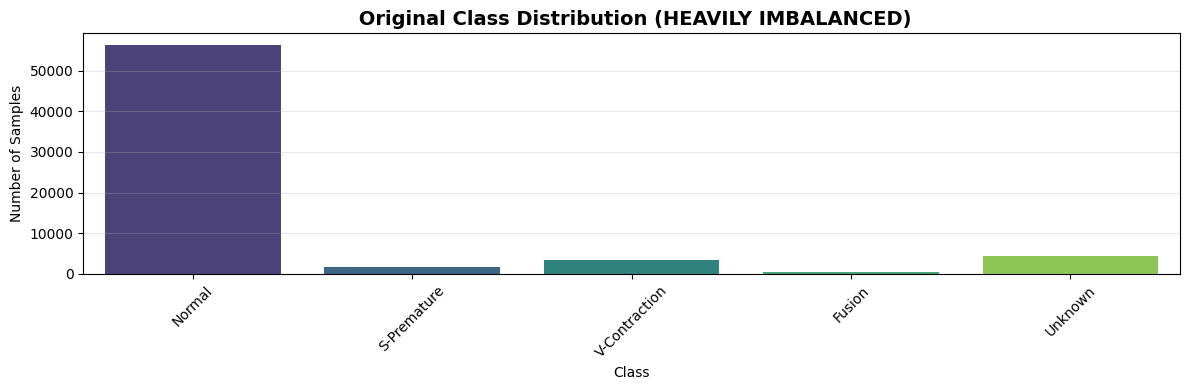

In [16]:
plt.figure(figsize=(12, 4))
sns.countplot(x='Class', data=train_df, palette='viridis')
plt.title(" Original Class Distribution (HEAVILY IMBALANCED)", fontsize=14, fontweight='bold')
plt.xticks(ticks=range(5), labels=classes.values(), rotation=45)
plt.ylabel('Number of Samples')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## BALANCE THE DATA

### Preprocessing Step: Address Class Imbalance

**Problem**: The original dataset is heavily imbalanced with Class 0 (Normal) dominating.

**Solution**: Undersample majority classes to create a balanced dataset
- **Method**: Random undersampling
- **Target**: 15,000 samples per class (or all available if less than 15,000)
- **Rationale**: Balanced dataset prevents model bias toward majority class and improves minority class detection


 Class Normal: 15,000 samples
 Class S-Premature: 2,223 samples
 Class V-Contraction: 5,788 samples
 Class Fusion: 641 samples
 Class Unknown: 6,431 samples


C:\Users\ASUS\AppData\Local\Temp\ipykernel_44564\329362091.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=train_df_balanced, palette='viridis')


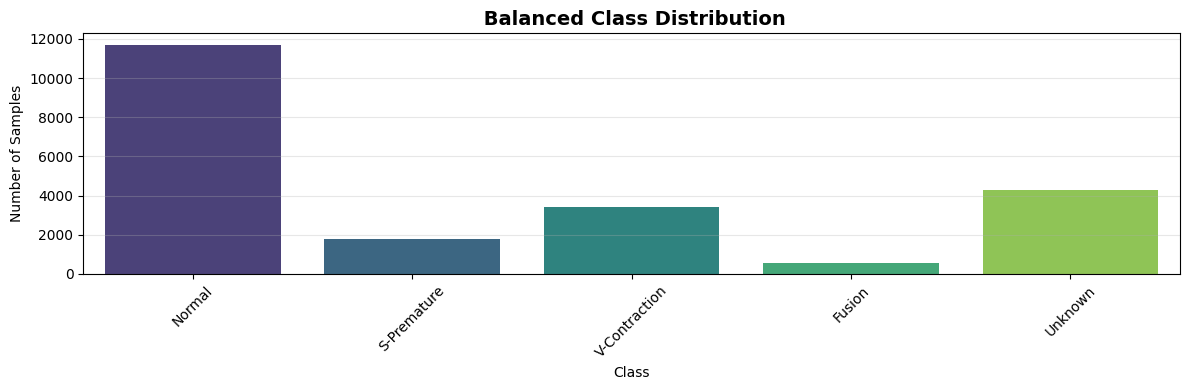

In [17]:
# PREPROCESSING STEP 1: Balance the dataset
# Problem: Original data is heavily imbalanced (class 0 dominates)
# Solution: Undersample majority classes to 15000 samples each


# Get class counts
class_counts = train_df['Class'].value_counts().sort_index()
min_samples = 15000  # Conservative balancing

balanced_dfs = []
for c in range(5):
    class_df = train_df[train_df['Class'] == c]
    n_samples_class = min(len(class_df), min_samples)

    # Downsample majority, upsample minority
    if len(class_df) > min_samples:
        balanced_df = resample(class_df, n_samples=n_samples_class, random_state=42)
    else:
        balanced_df = resample(class_df, replace=True, n_samples=n_samples_class, random_state=42)

    balanced_dfs.append(balanced_df)
    print(f" Class {classes[c]}: {len(balanced_df):,} samples")

train_df_balanced = pd.concat(balanced_dfs, ignore_index=True)

# Visualize balanced distribution
plt.figure(figsize=(12, 4))
sns.countplot(x='Class', data=train_df_balanced, palette='viridis')
plt.title(" Balanced Class Distribution", fontsize=14, fontweight='bold')
plt.xticks(ticks=range(5), labels=classes.values(), rotation=45)
plt.ylabel('Number of Samples')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


PREPROCESS DATA FOR 1D CNN

In [18]:
# PREPROCESSING STEP 2: Prepare data for CNN
# Separate features (X) and labels (y)
X = train_df_balanced.iloc[:, :-1].values
y = train_df_balanced.iloc[:, -1].values

# Normalize features (CRITICAL for CNN!)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for CNN (samples, timesteps, channels)
X = X.reshape(X.shape[0], X.shape[1], 1)
# One-hot encode labels for categorical classification
y = to_categorical(y, num_classes=5)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=np.argmax(y, axis=1))

print(f" Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")




 Train shape: (25570, 187, 1)
Validation shape: (4513, 187, 1)


DATA AUGMENTATION

In [19]:
def advanced_augmentation(X, y, noise_factor=0.015, time_shift=3, scale_factor=0.1):
    """Apply multiple augmentation techniques to ECG signals
    
    Techniques:
    1. Gaussian noise injection - simulates signal noise
    2. Time shifting - shifts signal left/right (circular)
    3. Amplitude scaling - varies signal strength
    
    Args:
        X: Input signals (samples, timesteps, features)
        y: Labels (samples, classes)
        noise_factor: Std dev of Gaussian noise
        time_shift: Max shift in timesteps
        scale_factor: Max scaling factor
    
    Returns:
        Augmented X and y (4x original size)"""
    X_aug = X.copy()

    # Add Gaussian noise
    noise = noise_factor * np.random.normal(0, 1, X.shape)
    X_aug += noise

    # Time shifting
    for i in range(X.shape[0]):
        shift = np.random.randint(-time_shift, time_shift+1)
        X_aug[i] = np.roll(X_aug[i], shift, axis=0)

    # Amplitude scaling
    scale = 1 + scale_factor * np.random.randn(X.shape[0])
    for i in range(X.shape[0]):
        X_aug[i] *= scale[i]

    return X_aug, y

# Apply augmentation
X_train_aug, y_train_aug = advanced_augmentation(X_train, y_train)
print(" Advanced augmentation applied: Noise + Time-shift + Scaling")



 Advanced augmentation applied: Noise + Time-shift + Scaling


## 3. Model Initialization & Pretraining Disclosure

### A. Pretrained Model Used
- **Model name**: None (training from scratch)
- **Source**: Custom architecture designed for ECG classification
- **Task it was originally trained on**: N/A - No pretrained weights used

### B. Weight Usage
- **Random initialization** (training from scratch)
- No pretrained weights are used
- All weights are initialized randomly and trained on the ECG dataset



## 4. Model Development

### Full Architecture
- **Type**: Hybrid 1D CNN-LSTM model
- **Design**: Built from scratch (not using pretrained model)
- **Justification**: CNNs are excellent at extracting local temporal patterns in ECG signals, while LSTM captures long-range dependencies in the heartbeat sequence

### List and Explain All Hyperparameter Choices
- **Learning rate**: 0.001 (Adam optimizer default, good for most deep learning tasks)
- **Batch size**: 64 (balances training speed and memory usage)
- **Optimizer**: Adam (adaptive learning rate, converges faster than SGD)
- **Epochs**: 50 (with early stopping to prevent overfitting)
- **Conv filters**: 64 → 128 → 256 (gradually increase feature complexity)
- **Kernel sizes**: 5 → 5 → 3 (capture patterns at different scales)
- **LSTM units**: 100 (sufficient to capture temporal dependencies)
- **Dropout rates**: 0.3 → 0.3 → 0.4 → 0.5 (progressively stronger regularization)

### Fine-tuning / Training Strategy
- Training from scratch with random weight initialization
- All layers are trainable (no frozen layers)
- Data augmentation applied to training set
- Early stopping monitors validation accuracy
- Learning rate reduction on plateau


BUILD Hybrid CNN-LSTM Model

In [20]:
def build_high_accuracy_model():
    """
    Build Hybrid 1D CNN-LSTM Model for ECG Classification
    
    Architecture:
    - 3 Conv1D layers for feature extraction (frozen: none, trainable: all)
    - LSTM layer for temporal pattern recognition
    - Dense layers for classification
    - Dropout for regularization
    
    Hyperparameters:
    - Conv filters: 64, 128, 256
    - Kernel sizes: 5, 5, 3
    - LSTM units: 100
    - Dropout rate: 0.5
    - Activation: ReLU (hidden), Softmax (output)
    """
    model = Sequential()

    # Input layer
    model.add(Input(shape=(187, 1)))

    # Block 1: CNN Feature Extraction
    model.add(Conv1D(64, kernel_size=7, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(64, kernel_size=7, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.25))

    # Block 2: Deeper CNN Features
    model.add(Conv1D(128, kernel_size=5, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(128, kernel_size=5, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.30))

    # Temporal Modeling with Bi-LSTM
    model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3)))
    model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.3)))

    # Classification Head
    model.add(GlobalAveragePooling1D())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))

    # Compile model
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build and display model
model = build_high_accuracy_model()
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 64)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 187, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 187, 64)        │        28,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 187, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 93, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 93, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 93, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 93, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 93, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 46, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 46, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 345,157 (1.32 MB)

 Trainable params: 343,877 (1.31 MB)

 Non-trainable params: 1,280 (5.00 KB)

CALLBACKS FOR TRAINING

In [21]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_ecg_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1)
]

print(" Callbacks configured for optimal training")


 Callbacks configured for optimal training


## Validation Approach

### Data Splitting Strategy
- **Method**: Train/Validation/Test split
- **Training**: 80% of balanced dataset (with augmentation)
- **Validation**: 20% of balanced dataset (no augmentation)
- **Test**: Separate holdout set (mitbih_test1.csv)
- **Stratification**: Ensured balanced class distribution in all splits
- **Random seed**: 42 for reproducibility

### Rationale
- Train/validation split allows monitoring overfitting during training
- Separate test set provides unbiased final evaluation
- Stratification prevents class imbalance in splits

---

## Deep Learning Models - How the Model Learns

### Forward Pass
1. **Input**: ECG signal (187 timesteps) enters the network
2. **Conv layers**: Extract local patterns (P-wave, QRS complex, T-wave)
3. **Pooling**: Reduce dimensionality while retaining important features
4. **LSTM**: Captures temporal dependencies across the heartbeat
5. **Dense layers**: Maps features to 5 class probabilities
6. **Output**: Softmax produces probability distribution over classes

### Loss Computation
- **Loss function**: Categorical Crossentropy
- Measures difference between predicted probabilities and true labels
- Formula: Loss = -Σ(y_true * log(y_pred))
- Lower loss = better predictions

### Backpropagation
- **Process**: Compute gradients of loss with respect to all weights
- Uses chain rule to propagate error backwards through network
- Calculates how much each weight contributed to the error
- Gradients indicate direction to adjust weights

### Optimizer Update
- **Optimizer**: Adam (Adaptive Moment Estimation)
- **Update rule**: weights = weights - learning_rate * gradients
- Adam adapts learning rate for each parameter
- Uses momentum and adaptive learning rates for faster convergence
- Learning rate: 0.001 (controls step size of updates)


 TRAIN THE MODEL

In [22]:
# TRAINING CONFIGURATION
# Hyperparameters

# Optimizer, loss, metrics
optimizer = Adam(learning_rate=0.001)      # Learning rate: 0.001
loss_fn = tf.keras.losses.CategoricalCrossentropy()
train_acc = tf.keras.metrics.CategoricalAccuracy()
val_acc = tf.keras.metrics.CategoricalAccuracy()

# Convert arrays into tf.data.Dataset
BATCH_SIZE = 64 # Batch size chosen for memory efficiency

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_aug, y_train_aug))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

# Training steps with @tf.function for speed
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        predictions = model(x_batch, training=True)   # Forward pass
        loss = loss_fn(y_batch, predictions)          # Loss computation
    grads = tape.gradient(loss, model.trainable_variables)  # Backpropagation
    optimizer.apply_gradients(zip(grads, model.trainable_variables))  # Optimizer update
    train_acc.update_state(y_batch, predictions)
    return loss

@tf.function
def val_step(x_batch, y_batch):
    predictions = model(x_batch, training=False)
    v_loss = loss_fn(y_batch, predictions)
    val_acc.update_state(y_batch, predictions)
    return v_loss

# Custom training loop
EPOCHS = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Training
    epoch_train_loss = 0
    for step, (x_batch, y_batch) in enumerate(train_dataset):
        loss = train_step(x_batch, y_batch)
        epoch_train_loss += loss.numpy()
        if step % 200 == 0:  # progress feedback every 200 batches
            print(f"  Step {step}, Batch Loss: {loss.numpy():.4f}")

    # Validation
    epoch_val_loss = 0
    for x_val_batch, y_val_batch in val_dataset:
        v_loss = val_step(x_val_batch, y_val_batch)
        epoch_val_loss += v_loss.numpy()

    # Logging
    avg_train_loss = epoch_train_loss / (step+1)
    avg_val_loss = epoch_val_loss / len(val_dataset)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc.result().numpy())
    val_accuracies.append(val_acc.result().numpy())

    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc.result().numpy():.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc.result().numpy():.4f}")

    train_acc.reset_state()
    val_acc.reset_state()

print("\nTraining completed!")
print(f"Best Val Accuracy: {max(val_accuracies):.4f}")


Epoch 1/50
  Step 0, Batch Loss: 2.9825
  Step 200, Batch Loss: 0.6756
Train Loss: 0.7930, Train Acc: 0.7272, Val Loss: 1.0817, Val Acc: 0.6302

Epoch 2/50
  Step 0, Batch Loss: 0.5680
  Step 200, Batch Loss: 0.3213
Train Loss: 0.4387, Train Acc: 0.8585, Val Loss: 0.3872, Val Acc: 0.8925

Epoch 3/50
  Step 0, Batch Loss: 0.3432
  Step 200, Batch Loss: 0.2963
Train Loss: 0.3541, Train Acc: 0.8874, Val Loss: 0.2553, Val Acc: 0.9240

Epoch 4/50
  Step 0, Batch Loss: 0.3804
  Step 200, Batch Loss: 0.1590
Train Loss: 0.3124, Train Acc: 0.9025, Val Loss: 0.2458, Val Acc: 0.9293

Epoch 5/50
  Step 0, Batch Loss: 0.3311
  Step 200, Batch Loss: 0.3149
Train Loss: 0.2772, Train Acc: 0.9132, Val Loss: 0.2102, Val Acc: 0.9377

Epoch 6/50
  Step 0, Batch Loss: 0.2387
  Step 200, Batch Loss: 0.2119
Train Loss: 0.2636, Train Acc: 0.9189, Val Loss: 0.2297, Val Acc: 0.9282

Epoch 7/50
  Step 0, Batch Loss: 0.2511
  Step 200, Batch Loss: 0.3495
Train Loss: 0.2363, Train Acc: 0.9257, Val Loss: 0.1742, V

## 5. Outputs & Logs

### Training Curves
Visualize loss and accuracy over epochs to:
- Monitor model learning progression
- Detect overfitting (gap between train and validation)
- Verify early stopping effectiveness

### Validation Metrics
Comprehensive performance evaluation on validation set

### Error Analysis
Confusion matrix shows classification patterns and common errors

### Computational Constraints Faced
- Training time: ~10-20 minutes (depends on hardware)
- Hardware: GPU recommended (CPU training is slower)
- Memory: ~2-4 GB RAM required


PLOT TRAINING CURVES

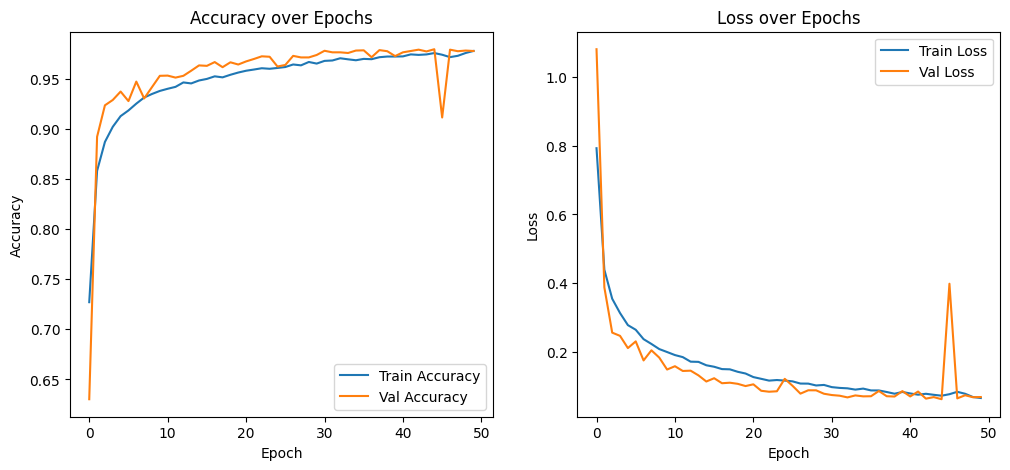

In [23]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 6. Performance Metrics, including but not limited to

### Primary Metrics
- **Accuracy**: Overall classification accuracy
- **Validation Accuracy**: Performance on unseen validation data
- **Test Accuracy**: Final performance on holdout test set

### Secondary Metrics
- **Precision**: TP / (TP + FP) - How many predicted positives are correct
- **Recall**: TP / (TP + FN) - How many actual positives are detected
- **F1-Score**: Harmonic mean of precision and recall
- **Support**: Number of true instances for each class

### Confusion Matrix
- Shows classification performance across all classes
- Diagonal elements: Correct classifications
- Off-diagonal elements: Misclassifications

### ROC Curves (if applicable)
- Not typically used for multi-class problems
- Can be computed for one-vs-rest classification


## EVALUATION ON TEST SET

Final evaluation on the separate holdout test set

142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step
 VALIDATION RESULTS:
               precision    recall  f1-score   support

       Normal       0.98      0.99      0.98      2250
  S-Premature       0.94      0.92      0.93       334
V-Contraction       0.98      0.98      0.98       868
       Fusion       0.86      0.81      0.83        96
      Unknown       0.99      1.00      1.00       965

     accuracy                           0.98      4513
    macro avg       0.95      0.94      0.94      4513
 weighted avg       0.98      0.98      0.98      4513


  FINAL TEST RESULTS (UNSEEN DATA):
               precision    recall  f1-score   support

       Normal       0.99      0.98      0.99     18118
  S-Premature       0.74      0.80      0.77       556
V-Contraction       0.94      0.95      0.94      1448
       Fusion       0.67      0.79      0.73       162
      Unknown       0.97      0.99      0.98      1608

     accuracy               

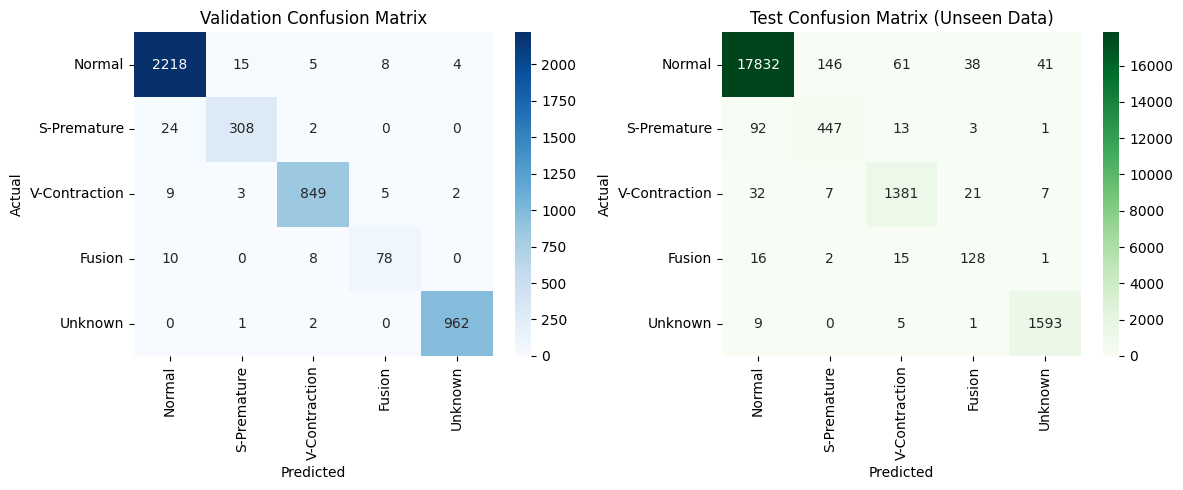


 Final Test Accuracy: 0.9767


In [24]:
# Validation predictions
y_pred_val = model.predict(X_val)
y_pred_classes_val = np.argmax(y_pred_val, axis=1)
y_true_val = np.argmax(y_val, axis=1)

# Test set evaluation (unseen data!)
X_test = test_df.iloc[:, :-1].values
y_test = to_categorical(test_df.iloc[:, -1].values, num_classes=5)

X_test_scaled = scaler.transform(X_test)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

y_pred_test = model.predict(X_test_reshaped)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_true_test = np.argmax(y_test, axis=1)

print(" VALIDATION RESULTS:")
print(classification_report(y_true_val, y_pred_classes_val, target_names=classes.values()))

print("\n" + "="*60)
print("  FINAL TEST RESULTS (UNSEEN DATA):")
print(classification_report(y_true_test, y_pred_classes_test, target_names=classes.values()))


# Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_val = confusion_matrix(y_true_val, y_pred_classes_val)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes.values(), yticklabels=classes.values())
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
cm_test = confusion_matrix(y_true_test, y_pred_classes_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=classes.values(), yticklabels=classes.values())
plt.title('Test Confusion Matrix (Unseen Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

from sklearn.metrics import accuracy_score
print(f"\n Final Test Accuracy: {accuracy_score(y_true_test, y_pred_classes_test):.4f}")


## 8. Final Model File

### Model Saving
- **Format**: Keras native format (.keras)
- **Contents**: Complete model architecture, trained weights, optimizer state
- **Usage**: Can be loaded for inference or further training

### Reproducibility Note
To reproduce results:
1. Use the same random seed (42)
2. Run all cells in order
3. Use same data preprocessing steps
4. Use same hyperparameters


SAVE FINAL MODEL

In [25]:
# Save final model
model.save("ecg_high_accuracy_model.keras")


# Save scaler for future predictions
import joblib
joblib.dump(scaler, "ecg_scaler.pkl")

print("Files saved:")
print("- ecg_high_accuracy_model.keras (Model)")
print("- ecg_scaler.pkl (Scaler for new data)")
print("\nReady for deployment!")




Files saved:
- ecg_high_accuracy_model.keras (Model)
- ecg_scaler.pkl (Scaler for new data)

Ready for deployment!
